In [21]:
from langgraph.graph import StateGraph,MessagesState,START,END
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from pydantic import BaseModel,Field
from dotenv import load_dotenv
import os

load_dotenv()

True

In [22]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [23]:
llm = ChatGroq(model_name="llama-3.3-70b-specdec")

In [24]:
llm.invoke("hi")

AIMessage(content="It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 36, 'total_tokens': 59, 'completion_time': 0.008582107, 'prompt_time': 0.004254924, 'queue_time': 0.202119313, 'total_time': 0.012837031}, 'model_name': 'llama-3.3-70b-specdec', 'system_fingerprint': 'fp_74379b522c', 'finish_reason': 'stop', 'logprobs': None}, id='run-39c1e20b-a054-47cb-9562-ca1af14448b8-0', usage_metadata={'input_tokens': 36, 'output_tokens': 23, 'total_tokens': 59})

In [25]:
class CityDetail(BaseModel):
    state_name:str = Field(description="State name of the city")
    state_capital:str = Field(description="State capital of the city")
    country_name:str = Field(description="Country name of the city")
    country_capital:str = Field(description="Country capital name of the city")

In [26]:
class AgentState(MessagesState):
    final_response : CityDetail

In [27]:
model_with_structure_output = llm.with_structured_output(CityDetail)

In [28]:
tavily_tool = TavilySearchResults(max_results=2) 

In [29]:
@tool
def get_city_details(prompt):
    "Should do a web search to find the required city details"
    response = tavily_tool.invoke(prompt)
    return response

In [30]:
get_city_details("who is the prime minister of india")

[{'url': 'http://www.pmindia.gov.in/en/',
  'content': "Shri Narendra Modi was sworn-in as India's Prime Minister for the third time on 9th June 2024, following another decisive victory in the 2024 Parliamentary"},
 {'url': 'https://en.wikipedia.org/wiki/Prime_Minister_of_India',
  'content': "Also, as the Minister of Personnel, Public Grievances and Pensions, the PM also exercises control over the Indian Administrative Service (IAS),[93] the country's premier civil service,[94][95] which staffs most of the senior civil service positions;[94][95] the Public Enterprises Selection Board (PESB);[96][97] and the Central Bureau of Investigation (CBI),[96][97] except for the selection of its director, who is chosen by a committee of: (a) the prime minister, as chairperson; (b) the leader of the opposition in Lok Sabha; and (c) the chief justice.[98]\nUnlike most other countries, the prime minister does not have much influence over the selection of judges, that is done by a collegium of judge

In [31]:
tool = [get_city_details]

In [32]:
tavely_tool = ToolNode(tool)

In [ ]:
def tool_node(self):
    tavely_tool = ToolNode(tool)
    return tavely_tool

In [33]:
model_with_llm = llm.bind_tools(tool)

In [34]:
def call_model(state: AgentState):
    message = state['messages']
    response = model_with_llm.invoke(message)
    return {'messages':[response]}

In [35]:
call_model({'messages':["hi"]})['messages'][-1].content

"I can help you find city details if you provide the name of the city you're interested in."

In [36]:
def router(state: AgentState):
    messages = state['messages'][-1]
    if messages.tool_calls:
        return "tool"
    else:
        return "response"

In [37]:
def response(state: AgentState):
    messages = state['messages'][-1].content
    response = model_with_structure_output.invoke([HumanMessage(content=messages)])
    return {"final_response":response}

In [ ]:
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("llm", call_model)
workflow.add_node("tools", tool_node)
workflow.add_node("respond", response)


# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("llm")

# We now add a conditional edge
workflow.add_conditional_edges(
    "llm",
    
    router,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "llm")
workflow.add_edge("respond", END)
graph = workflow.compile()

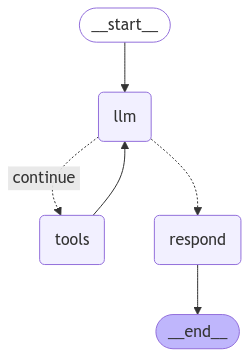

In [39]:
graph

In [40]:
answer = graph.invoke(input={"messages": [("human", "Tell me about the city details for gwalior?")]})['final_response']

KeyError: 'tool'

In [ ]:
output

NameError: name 'output' is not defined